# Loan Default Prediction
## Team Members:
* Harish Puvvada
* Vamsi Mohan Ramineedi

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:
df2012_13 = pd.read_csv(os.getenv('FDS')+'LoanStats_2012_to_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv(os.getenv('FDS')+'LoanStats_2014.csv',low_memory=False,skiprows=1)

## Data Cleaning

In [3]:
dataset = pd.concat([df2012_13, df2014]) #merging 2007 to 2014 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [4]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (376233, 82)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,Team Leadern Customer Ops & Systems,10+ years,OWN,55000.0,Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,Debt Consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,NaN,NaN,14.0,0.0,36638.0,61.2%,27.0,w,0.0,0.0,31752.530000,...,3.0,9570.0,16473.0,53.9,0.0,0.0,117.0,326.0,16.0,6.0,4.0,16.0,NaN,8.0,NaN,0.0,2.0,4.0,4.0,8.0,8.0,10.0,15.0,4.0,14.0,0.0,0.0,0.0,1.0,100.0,25.0,0.0,0.0,138554.0,70186.0,35700.0,33054.0
1,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,Project Manager,4 years,RENT,60000.0,Not Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > I would like to...,debt_consolidation,No Regrets,281xx,NC,4.62,0.0,Dec-2009,1.0,NaN,NaN,15.0,0.0,7137.0,24%,18.0,f,0.0,0.0,13988.609996,...,8.0,476.0,15216.0,15.9,0.0,0.0,NaN,48.0,1.0,1.0,0.0,1.0,NaN,3.0,NaN,0.0,4.0,7.0,8.0,10.0,0.0,15.0,18.0,7.0,15.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0
2,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,Surgical Technician,2 years,MORTGAGE,39600.0,Source Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Just bought a h...,home_improvement,For The House,782xx,TX,2.49,0.0,Aug-1995,2.0,NaN,NaN,3.0,0.0,4136.0,16.1%,8.0,w,0.0,0.0,5157.519457,...,0.0,1379.0,21564.0,16.1,0.0,0.0,104.0,220.0,25.0,25.0,0.0,25.0,NaN,3.0,NaN,0.0,2.0,2.0,3.0,4.0,1.0,3.0,7.0,2.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,25700.0,4136.0,25700.0,0.0


In [5]:
#print(Dataset_withBoolTarget.shape)
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
#print(x.isnull().sum()) #- to check how many null values in all the columns
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (376233, 74)


In [6]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (376233, 52)


In [7]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (376233, 18)


## Data Transformation


In [8]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (376233, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,27050.0,10,55000.0,4,6,6074.19,4.0,0.0,10.99,14.0,4.0,16.0,326.0,53.9,16473.0,9570.0,3.0,0
1,12000.0,4,60000.0,5,6,3775.55,0.0,0.0,10.99,15.0,7.0,1.0,48.0,15.9,15216.0,476.0,8.0,0
2,4800.0,2,39600.0,6,6,3900.48,0.0,0.0,10.99,3.0,2.0,25.0,220.0,16.1,21564.0,1379.0,0.0,0
3,12000.0,10,130000.0,6,6,398.28,3.0,0.0,11.99,9.0,5.0,4.0,193.0,93.0,3567.0,36362.0,4.0,0
4,7550.0,3,28000.0,5,5,529.67,0.0,0.0,16.24,4.0,4.0,17.0,38.0,96.0,160.0,1440.0,1.0,0


In [9]:
#Final_data[Final_data['loan_status']==0]["last_pymnt_amnt"].value_counts()

## Filling Missing values and Feature scaling 


In [10]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (376233, 18)


In [11]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1] 
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    310035
1     66198
Name: loan_status, dtype: int64

In [12]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=70000)
data_clean = pd.concat([loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (136198, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,-0.506304,1.140751,-0.336369,-0.634134,0.591081,-0.692260,1.015556,-0.323888,-0.163021,-0.263079,0.448250,-0.673570,1.011269,1.145170,-0.608502,-0.301117,-0.445595,1
1,-0.750339,-1.053656,-0.354469,-2.167321,-0.950935,-0.700268,-0.840272,-0.323888,0.854627,-1.472918,-0.928200,9.512782,-0.169968,0.754009,-0.472294,-0.567348,-1.168306,0
2,-0.823550,1.140751,-0.835663,0.899053,0.591081,-0.707392,1.479513,-0.323888,-0.613531,-1.271278,-0.928200,4.058155,-0.055285,0.830707,-0.439613,-0.373638,-1.529662,0
3,-0.506304,-1.327957,-0.761633,0.899053,-0.179927,-0.690316,-0.376315,-0.323888,0.408691,-0.666359,-0.584087,-0.739288,-1.752598,0.470224,-0.534761,0.332285,0.638473,1
4,1.025017,-0.505054,-0.169394,0.899053,-0.179927,-0.659917,-0.376315,-0.323888,0.340086,-0.464719,-0.584087,-0.673570,0.334638,-0.825979,0.771559,0.503686,-0.084239,1


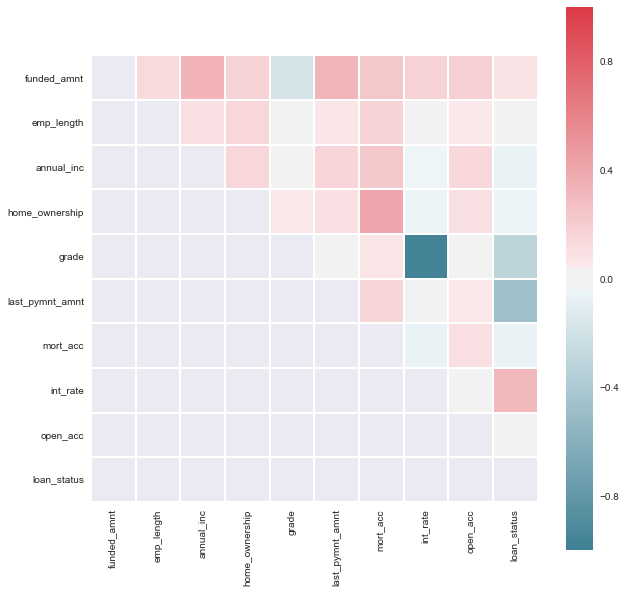

In [13]:
dataViz = data_clean[['funded_amnt','emp_length','annual_inc','home_ownership','grade','last_pymnt_amnt','mort_acc','int_rate','open_acc','loan_status']]

sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

## Algorithms


## Random Forest


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.33, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.33, random_state=42) #just for bootstrapping

In [15]:
randomForest = RandomForestClassifier(criterion = "gini")
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.820206469986


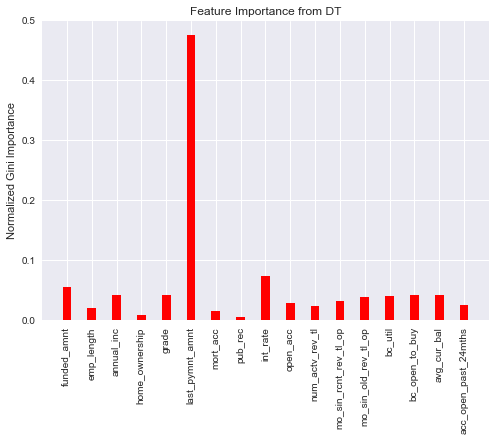

In [16]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(fields)), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

## ROC-AUC curve plot function


In [17]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

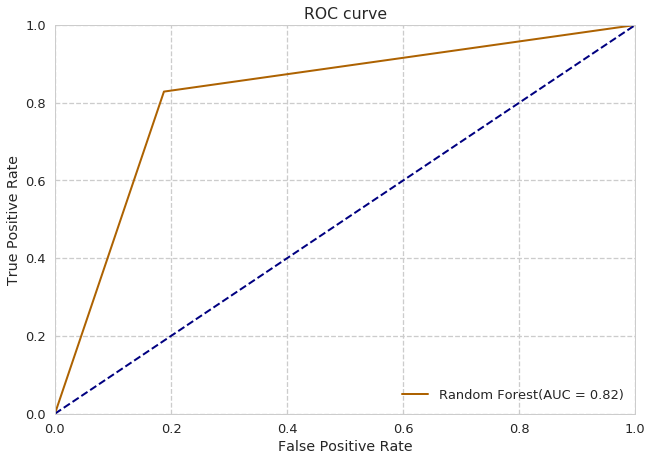

Average precision-recall score: 0.86


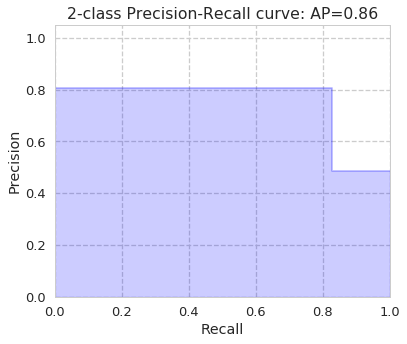

In [18]:
plotAUC(y_test,rfPredict, 'Random Forest')
plt.show()

average_precision = average_precision_score(y_test, rfPredict)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, rfPredict)
plt.figure(figsize=(6,5))
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## Logistic Regression


0.828594313176


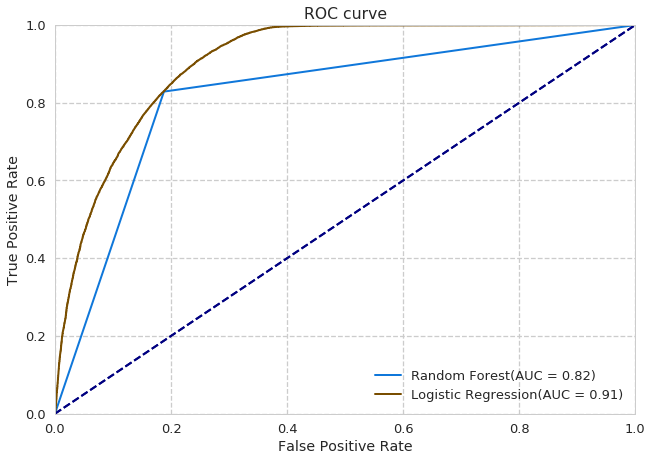

[  9.28607751e-01   3.89786303e-01   5.63829556e-01 ...,   8.12718660e-01
   7.78027803e-01   1.20465162e-11]
Average precision-recall score: 0.87


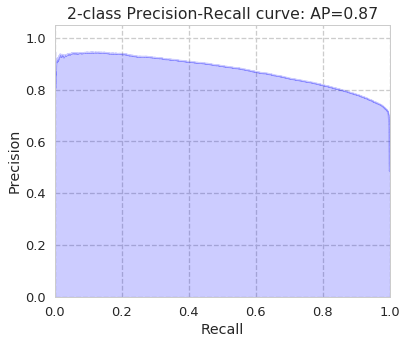

In [30]:
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print(LR_Accuracy)
plotAUC(y_test,rfPredict, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
average_precision = average_precision_score(y_test, LR_Predict)
print(LR_Predict)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
precision, recall, _ = precision_recall_curve(y_test, LR_Predict)
plt.figure(figsize=(6,5))
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## Support Vector Machines(SVM)


0.826903395185


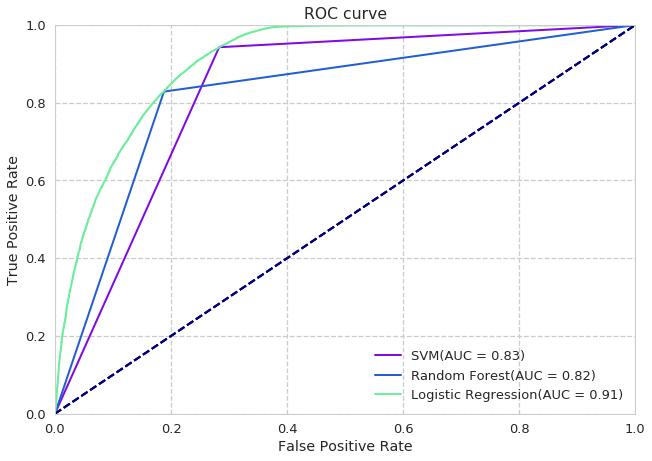

In [20]:
clf_svm = svm.SVC(kernel = "rbf")
clf_svm.fit(X_train.iloc[:,[0,4,5,8]],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,[0,4,5,8]])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print(SVM_Accuracy)
plotAUC(y_test,predictions_svm, 'SVM')
plotAUC(y_test,rfPredict, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()

## K Nearest Neighbours(KNN)


In [21]:
from sklearn.neighbors import KNeighborsClassifier

def knnfunc(k1,k2):
    accuracies = []
    listofPred = np.array([])
    for k in range(k1,k2):
        clf_knn = KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(X_train,y_train)
        knn_pred = clf_knn.predict(X_test)
        KNN_Accuracy = accuracy_score(y_test,knn_pred)
        #listofPred.append(knn_pred)
        accuracies.append(KNN_Accuracy)
    return accuracies #returning max accuracy and its predictions

#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1

[0.76336047701686471]


NameError: name 'KNN_Predict' is not defined

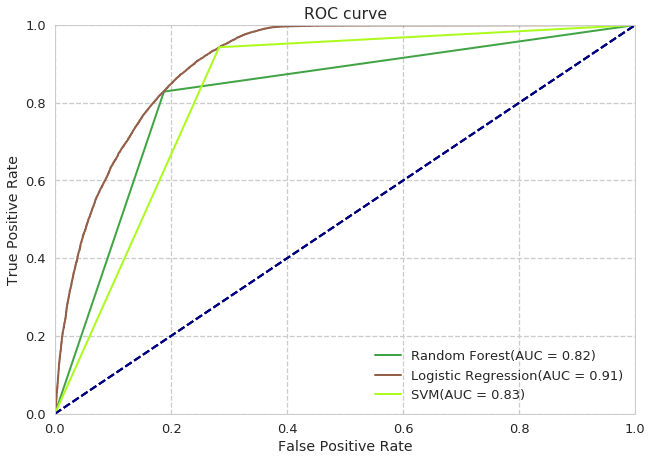

In [27]:
KNN_Acc = knnfunc(30,31)
print(KNN_Acc)
#print(KNN_Predict.index(max(KNN_Acc)))
plotAUC(y_test,rfPredict, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictions_svm, 'SVM')
plotAUC(y_test,KNN_Predict,'K Nearest Neighbors')
plt.show()

## Bootstrapping to find errors

In [23]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (lr == 1):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Linear regression fitting and predicting if lr==1
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        else:
            svm_i = svm.SVC(kernel='rbf', C = c) #hardcoding the value since it is negative power error.
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

SampleSizes = [25000, 50000, 75000] #various samples of dataset , 100000, 125000, 136000

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, 1, 0.1)# collecting means and stderrs for LR model
    print(n)
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n, 0, 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

25000


KeyboardInterrupt: 

## Bagging for Classification

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

## Ada Boost classifier

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
scores.mean()

0.83253056816928084

## Confusion Matrix plot

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()
plt.figure(figsize=(6,6))
#plot_confusion_matrix(LR_Predict, normalize=True)
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## Precision,recall,F1score for all algorithms

In [29]:
from sklearn.metrics import classification_report
print("Randome forest",classification_report(y_test, rfPredict, target_names=None))         
print("Logistic Regression",classification_report(y_test, LR_Predict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
#print("KNN",classification_report(y_true, KNN_Predict, target_names=None))
#print("Bagging",classification_report(y_true, y_pred, target_names=None))
#print("Ada Boost",classification_report(y_true, y_pred, target_names=None))

Randome forest              precision    recall  f1-score   support

          0       0.83      0.81      0.82     23080
          1       0.81      0.83      0.82     21866

avg / total       0.82      0.82      0.82     44946



ValueError: Mix type of y not allowed, got types {'continuous', 'binary'}

## Things to be done

In [26]:
Important...
### bootstrapping, boosting
### Data Exploration - few more insights -- ask TA about the visualization mistake

Harish:
### annual income, funded amount ----> create new var
### KNN pred problem
### classification report

Vamsi
### PCA
###cross validation


More work...
### Reduce number of  features , extra - acc_now_delinq, pct_tl_nvr_dlq, num_sats, sub_grade

Final Submission...
### report - Prob moti, target var and features defined, motivation for each model, eval approaches, assumption and limitations
### Final IPynb with clear comments, how to give data??
### Github Read me edit for your own sake

SyntaxError: invalid syntax (<ipython-input-26-3e9f1fcd564b>, line 1)